In [58]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
import joblib

stopWords = set(stopwords.words('english'))

In [59]:
df = pd.read_csv('../resources/ml_data.csv')

In [60]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Sr Data Scientist,$137K-$171K (Glassdoor est.),Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst\n3.1,"New York, NY",1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable
1,Data Scientist,$137K-$171K (Glassdoor est.),"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech\n4.2,"Chantilly, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD)
2,Data Scientist,$137K-$171K (Glassdoor est.),Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group\n3.8,"Boston, MA",1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD)
3,Data Scientist,$137K-$171K (Glassdoor est.),JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON\n3.5,"Newton, MA",501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD)
4,Data Scientist,$137K-$171K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable


In [61]:
#Get the datas with salary with glassdoor estimate
df['Salary_est'] = df['Salary Estimate'].apply(lambda x: 1 if 'glassdoor est.' in x.lower() else 0)
df = df[df['Salary_est'] == 1]

In [62]:
# Calculate average salary and drop non-useful columns
salary = df['Salary Estimate'].apply(lambda x: x.split('(')[0])
minus_Kd = salary.apply(lambda x: x.replace('K','').replace('$',''))

df['min_salary'] = minus_Kd.apply(lambda x: int(x.split('-')[0]))
df['max_salary'] = minus_Kd.apply(lambda x: int(x.split('-')[1]))
df['Salary'] = (df.min_salary+df.max_salary)*1000/2
df = df.drop(['Salary Estimate', 'Salary_est', 'min_salary', 'max_salary'],1)

In [63]:
# Company name text only
df['Company Name'] = df.apply(lambda x: x['Company Name'] if x['Rating'] <0 else x['Company Name'].split('\n')[0], axis = 1)

In [64]:
# Create new features such as city & state 
df['City'] = df['Location'].apply(lambda x: x.split(',')[0] if ',' in x.lower() else x)
df['State'] = df['Location'].apply(lambda x: x.split(',')[1] if ',' in x.lower() else x) 
df = df.drop(['Location'],1)
df.head()

,Job Title,Job Description,Rating,Company Name,Size,Founded,Type of ownership,Industry,Sector,Revenue,Salary,City,State
0,Sr Data Scientist,Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,1001 to 5000 employees,1993,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,154000.0,New York,NY
1,Data Scientist,"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),154000.0,Chantilly,VA
2,Data Scientist,Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,1001 to 5000 employees,1981,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),154000.0,Boston,MA
3,Data Scientist,JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,501 to 1000 employees,2000,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),154000.0,Newton,MA
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,154000.0,New York,NY


In [65]:
# Calculate the age of company 
df['Founded'] = df['Founded'].apply(lambda x: np.nan if x in ['Company - Private', '-1', 'Company - Public', 'Unknown', 'Contract', 'Nonprofit Organization', 'Self-employed'] else x)
df['Age'] = df['Founded'].apply(lambda x: x if x is np.nan else 2021 - int(x))
df = df.drop(['Founded'],1)

In [66]:
# Python
df['Python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
 
# R studio 
df['R'] = df['Job Description'].apply(lambda x: 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)

# SQL 
df['SQL'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)

# AWS 
df['AWS'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)

# Excel
df['Excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)

# Google Cloud
df['GCP'] = df['Job Description'].apply(lambda x: 1 if 'google cloud' in x.lower() or 'gcp' in x.lower() else 0)

# Microsoft Azure
df['Azure'] = df['Job Description'].apply(lambda x: 1 if 'microsoft azure' in x.lower() or 'azure' in x.lower() else 0)

# Spark
df['Spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)

# PyTorch
df['PyTorch'] = df['Job Description'].apply(lambda x: 1 if 'pytorch' in x.lower() else 0)

# TensorFlow
df['TensorFlow'] = df['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() else 0)

# Tableau
df['Tableau'] = df['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)

# Keras
df['Keras'] = df['Job Description'].apply(lambda x: 1 if 'keras' in x.lower() else 0)

#NoSQL
df['NoSQL'] = df['Job Description'].apply(lambda x: 1 if 'nosql' in x.lower() else 0)

#Sci-kit Learn
df['Scikit-Learn'] = df['Job Description'].apply(lambda x: 1 if 'scikit learn' in x.lower() else 0)

#Machine Learning
df['Machine_Learning'] = df['Job Description'].apply(lambda x: 1 if 'machine learning' in x.lower() else 0)

#Hadoop
df['Hadoop'] = df['Job Description'].apply(lambda x: 1 if 'hadoop' in x.lower() else 0)

# Scala
df['Scala'] = df['Job Description'].apply(lambda x: 1 if 'scala' in x.lower() else 0)

# Data Brick
df['Data_Brick'] = df['Job Description'].apply(lambda x: 1 if 'data brick' in x.lower() else 0)

In [67]:
# Convert size to lower case
df['Size'] = df['Size'].str.lower()
df.head()

,Job Title,Job Description,Rating,Company Name,Size,Type of ownership,Industry,Sector,Revenue,Salary,...,PyTorch,TensorFlow,Tableau,Keras,NoSQL,Scikit-Learn,Machine_Learning,Hadoop,Scala,Data_Brick
0,Sr Data Scientist,Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,1001 to 5000 employees,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,154000.0,...,0,0,0,0,0,0,1,0,0,0
1,Data Scientist,"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,5001 to 10000 employees,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),154000.0,...,0,0,0,0,0,0,1,1,0,0
2,Data Scientist,Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,1001 to 5000 employees,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),154000.0,...,0,0,0,0,0,0,1,0,0,0
3,Data Scientist,JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,501 to 1000 employees,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),154000.0,...,1,1,0,0,1,0,1,0,0,0
4,Data Scientist,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,154000.0,...,0,0,0,0,0,0,1,0,0,0


In [68]:
df['Job Title'] = df['Job Title'].apply(lambda x: ' '.join(x.split()))
df['Job Title'] = df['Job Title'].apply(lambda x: re.sub(r'[^\w\s]',' ', x.lower()))
df['Job Description'] = df['Job Description'].apply(lambda x: ' '.join(x.split()))
df['Job Description'] = df['Job Description'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
df['Job Description'] = df['Job Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopWords]))   

In [69]:
# Classifying job titles into each category
def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'data analyst'
    elif 'machine learning' in title.lower():
        return 'machine learning engineer'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'data science related jobs'


In [70]:
# Classifying job levels into each category
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'vp' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower()or 'experienced' in title.lower() or 'iii' in title.lower() or 'research' in title.lower() or 'manager' in title.lower():
        return 'Senior'
    elif 'intermediate' in title.lower() or 'staff' in title.lower() or 'ii' in title.lower():
        return 'Mid'
    elif 'jr' in title.lower() or 'junior' in title.lower() or 'intern' in title.lower() or 'student' in title.lower()or 'associate' in title.lower():
        return 'Junior'
    else:
        return 'Not Specified'

In [71]:
# Process data based on above defined functions 
df['Job'] = df['Job Title'].apply(title_simplifier)
df['Seniority'] = df['Job Title'].apply(seniority)

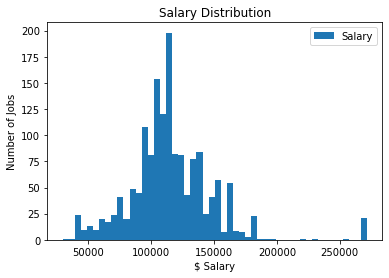

In [72]:
import matplotlib.pyplot as plt
x = list(df.Salary)

names = ['Salary']
         
plt.hist([x], bins = 50,
         label=names)

plt.legend()
plt.xlabel('$ Salary')
plt.ylabel('Number of Jobs')
plt.title('Salary Distribution')
# Remove outliers
df = df[50000 <= df['Salary']]
df = df[df['Salary'] < 200000]


In [73]:
# Categorize salary
def salary_category(salary):

    if salary < 100000:
        return 1
    if salary < 150000:
        return 2
    if salary < 200000:
        return 3

target = df['Salary'].apply(salary_category)

In [74]:
# Fill all NaN values in numeric & text features 
df['Age'] = df['Age'].fillna(0)
df = df.fillna('Unknown')

In [75]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [76]:
df=df.drop(["Rating","Company Name","City","Revenue",'Type of ownership',
                                                            'Sector'],axis=1)

In [77]:
features= [c for c in df.columns.values if c not in ['Salary']]
numeric_features= [c for c in df.columns.values if c not in ['Job Title','Size','State','Job','Seniority',"Job Description","Industry"]]

X_train, X_test, y_train, y_test = train_test_split(df[features], target, test_size=0.2, random_state=42)
X_train.head(2)

,Job Title,Job Description,Size,Industry,State,Age,Python,R,SQL,AWS,...,Tableau,Keras,NoSQL,Scikit-Learn,Machine_Learning,Hadoop,Scala,Data_Brick,Job,Seniority
573,data scientist,meridian knowledge solutions llc leading provi...,51 to 200 employees,Enterprise Software & Network Solutions,DC,24.0,0,0,0,0,...,0,0,0,0,1,0,0,0,data scientist,Not Specified
575,data scientist,date posted 20181022 location various location...,1 to 50 employees,Consulting,TX,0.0,1,0,0,0,...,0,0,0,0,1,0,0,0,data scientist,Not Specified


In [78]:

# Define text feature pipelines
jt=TextSelector(key='Job Title')
s=TextSelector(key='Size')
o=TextSelector(key='Type of ownership')
i=TextSelector(key='Industry')
sec=TextSelector(key='Sector')
state= TextSelector(key='State')
j=TextSelector(key='Job')
Job_Title = Pipeline([
                ('selector', jt),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Size = Pipeline([
                ('selector', s),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Description = Pipeline([
                ("selector",TextSelector("Job Description")),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

State = Pipeline([
                ('selector',state),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])

Job = Pipeline([
                ('selector',j ),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])
Industry = Pipeline([
                ('selector',i ),
                ('tfidf', TfidfVectorizer(stop_words='english'))
            ])
Job_Title.fit_transform(X_train)

<1193x484 sparse matrix of type '<class 'numpy.float64'>'
	with 3852 stored elements in Compressed Sparse Row format>

In [79]:

a=NumberSelector(key='Age')
p=NumberSelector(key='Python')
r= NumberSelector(key='R')
sql=NumberSelector(key='SQL')
aws=NumberSelector(key='AWS')
excel=NumberSelector(key='Excel')
gcp=NumberSelector(key='GCP')
az=NumberSelector(key='Azure')
spark=NumberSelector(key='Spark')
t=NumberSelector(key='PyTorch')
tensor=NumberSelector(key='TensorFlow')
tab=NumberSelector(key='Tableau')
k= NumberSelector(key='Keras')
nosql= NumberSelector(key='NoSQL')
sk=NumberSelector(key='Scikit-Learn')
ml= NumberSelector(key='Machine_Learning')
h=NumberSelector(key='Hadoop')
scala=NumberSelector(key='Scala')
db=NumberSelector(key='Data_Brick')
Age =  Pipeline([
                ('selector', a),
                ('standard', StandardScaler())
            ])
Python =  Pipeline([
                ('selector', p),
                ('standard', StandardScaler())
            ])
R =  Pipeline([
                ('selector',r),
                ('standard', StandardScaler()),
            ])
SQL =  Pipeline([
                ('selector', sql),
                ('standard', StandardScaler()),
            ])
AWS =  Pipeline([
                ('selector', aws),
                ('standard', StandardScaler()),
            ])
Excel =  Pipeline([
                ('selector', excel),
                ('standard', StandardScaler()),
            ])
GCP =  Pipeline([
                ('selector', gcp),
                ('standard', StandardScaler()),
            ])
Azure =  Pipeline([
                ('selector', az),
                ('standard', StandardScaler()),
            ])
Spark =  Pipeline([
                ('selector', spark),
                ('standard', StandardScaler()),
            ])
Tableau =  Pipeline([
                ('selector', tab),
                ('standard', StandardScaler()),
            ])

Keras =  Pipeline([
                 ('selector',k),
                 ('standard', StandardScaler()),
             ])
NoSQL =  Pipeline([
                ('selector',nosql),
                ('standard', StandardScaler()),
            ])
Machine_Learning =  Pipeline([
                ('selector', ml),
                ('standard', StandardScaler()),
            ])
Hadoop =  Pipeline([
                ('selector', h),
                ('standard', StandardScaler()),
            ])

In [80]:
# FeatureUnion for all feature vectors 
feats = FeatureUnion([('Job Title', Job_Title), 
                      ('Company Size', Size),
                      ('Industry', Industry),

                      ('State', State),
                      ('Job', Job),

                      ('Age', Age),
                      ('Python', Python),
                      ('R', R),
                      ('SQL', SQL),
                      ('AWS', AWS),
                      ('Excel', Excel),
                      ('GCP', GCP),
                      ('Azure', Azure),
                      ('Spark', Spark),
                      # ('PyTorch', PyTorch),
                      # ('TensorFlow', TensorFlow),
                      ('Keras',Keras),
                      ('Tableau', Tableau),
                      ('NoSQL', NoSQL),
                      # ('Scikit_Learn', Scikit_Learn),
                      ('Machine_Learning',Machine_Learning),
                      ('Hadoop', Hadoop),

                     ])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<1193x725 sparse matrix of type '<class 'numpy.float64'>'
	with 28761 stored elements in Compressed Sparse Row format>

In [81]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Job Title',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='Job '
                                                                                   'Title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(stop_words='english'))])),
                                                ('Company Size',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='Size')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(stop_words='english'))])),
                                           

In [82]:
preds=pipeline.predict(X_test)
preds

array([2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 3, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1,
       2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 2, 3,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2], dtyp

In [85]:
# Define a custom accuracy evaluation function 
def evaluate(preds, y_test, variation):
    counter = 0
    for i in range(len(preds)):
        if y_test[i]-variation <= preds[i] <= y_test[i]+variation:
            counter += 1
        else: 
            counter += 0
    accuracy = counter / len(preds) 
    return accuracy
        
evaluate(list(preds), list(y_test), 1)

0.6287625418060201

In [84]:

joblib.dump(pipeline, 'salary_predict_model.pkl')

['salary_predict_model.pkl']